In [26]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from pickle import dump
from sklearn.decomposition import PCA

In [27]:
# pandas option 설정 하는 코드
# monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('display.float_format')

# 데이터 로드

In [28]:
path = "./competition_data/"

data = pd.read_csv(path+"train.csv")

# original data -> data
data

,index,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,engnat,age,hand,religion,orientation,voted,married,familysize,ASD,nerdiness
0,0,1.00,5.00,5.00,5.00,1.00,4.00,5.00,5.00,1.00,...,1.00,20,2.00,12.00,4.00,2.00,1.00,4.00,2.00,1
1,1,4.00,4.00,4.00,4.00,4.00,5.00,4.00,4.00,3.00,...,1.00,49,1.00,2.00,1.00,1.00,2.00,4.00,2.00,1
2,2,4.00,5.00,5.00,4.00,3.00,5.00,5.00,5.00,4.00,...,2.00,43,1.00,2.00,2.00,2.00,3.00,4.00,2.00,1
3,3,4.00,4.00,4.00,2.00,4.00,3.00,3.00,5.00,3.00,...,1.00,17,2.00,1.00,1.00,2.00,1.00,2.00,2.00,1
4,4,4.00,4.00,4.00,4.00,3.00,3.00,4.00,2.00,3.00,...,2.00,18,2.00,12.00,1.00,2.00,1.00,1.00,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,2.00,5.00,4.00,3.00,3.00,4.00,4.00,4.00,3.00,...,1.00,17,1.00,1.00,3.00,2.00,1.00,3.00,2.00,0
14996,14996,5.00,4.00,5.00,4.00,4.00,5.00,5.00,4.00,4.00,...,2.00,45,1.00,3.00,1.00,1.00,2.00,3.00,2.00,1
14997,14997,4.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,4.00,...,1.00,20,1.00,1.00,2.00,1.00,1.00,3.00,1.00,1
14998,14998,5.00,5.00,4.00,5.00,5.00,5.00,5.00,1.00,5.00,...,1.00,29,1.00,12.00,4.00,2.00,2.00,2.00,1.00,0


# 전처리

In [29]:
processed_data = data.drop(['index','country'], axis=1).copy()

Q_cols = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11','Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21','Q22', 'Q23','Q24','Q25','Q26']
TIP_cols = ['TIPI1', 'TIPI2', 'TIPI3', 'TIPI4','TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10']
VCL_cols = ['VCL1', 'VCL2','VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10','VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16']

Q_data = processed_data[Q_cols].copy()
TIP_data = processed_data[TIP_cols].copy()
VCL_data = processed_data[VCL_cols].copy()

## mice

In [30]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer_mice = IterativeImputer(random_state=83)
Q_data= imputer_mice.fit_transform(Q_data)
Q_data = pd.DataFrame(Q_data, columns = Q_cols)

imputer_mice = IterativeImputer(random_state=82)
TIP_data= imputer_mice.fit_transform(TIP_data)
TIP_data = pd.DataFrame(TIP_data, columns = TIP_cols)


imputer_mice = IterativeImputer(random_state=81)
VCL_data= imputer_mice.fit_transform(VCL_data)
VCL_data = pd.DataFrame(VCL_data, columns = VCL_cols)


In [31]:
processed_data = processed_data.drop(Q_cols, axis=1)
processed_data = processed_data.drop(TIP_cols, axis=1)
processed_data = processed_data.drop(VCL_cols, axis=1)

processed_data = pd.concat([processed_data,Q_data],axis=1)
processed_data = pd.concat([processed_data,TIP_data],axis=1)
processed_data = pd.concat([processed_data,VCL_data],axis=1)

<AxesSubplot:>

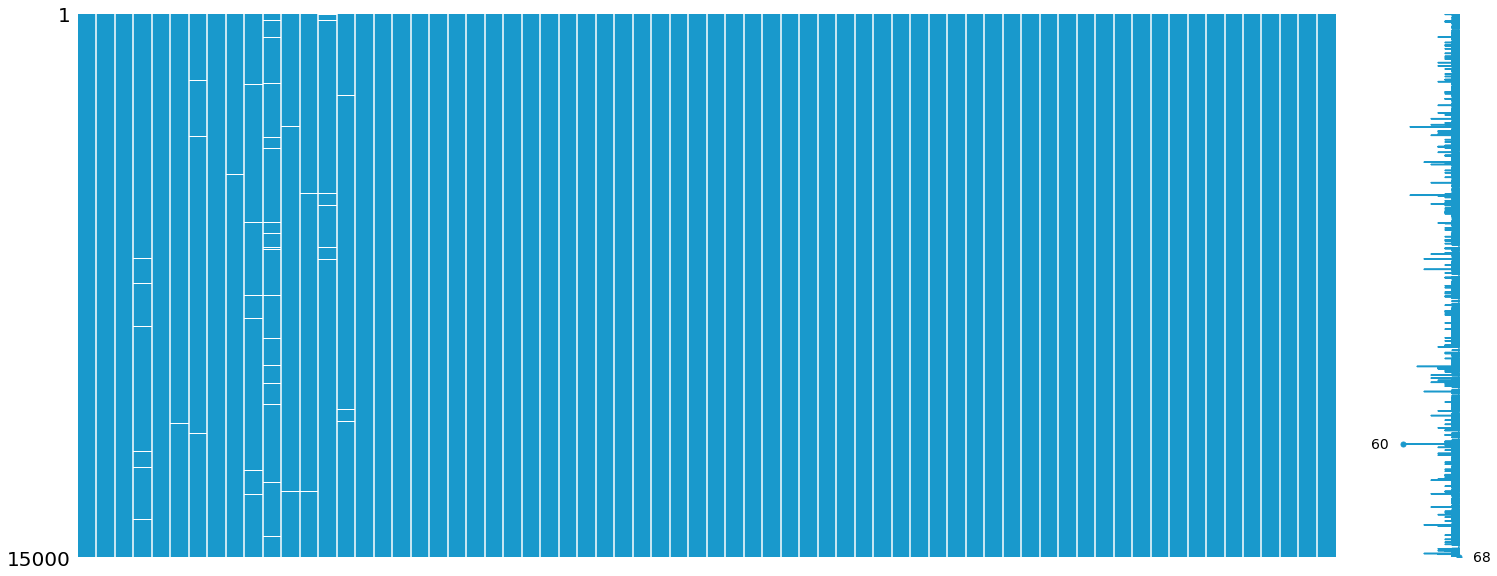

In [32]:
#결측치가 대체된 모습을 확인 할 수 있다. 
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

## 설문 문항 외 전처리

In [33]:
#필요없는 항 삭제, 결측치에 0으로 대체 >> 0으로 대체 하는게 맞나

fill_cols = ['education', 'gender', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD','age']
processed_data = processed_data.dropna()

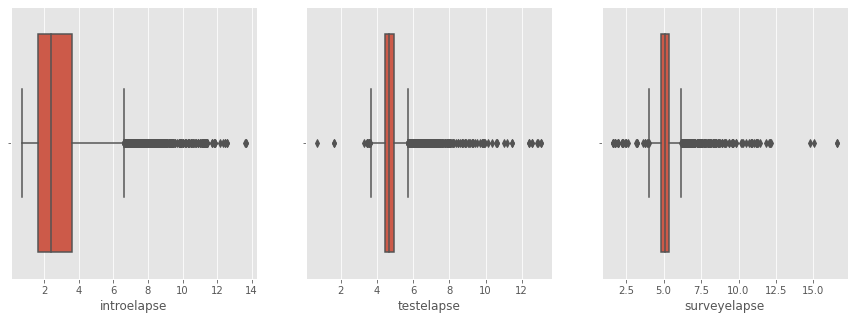

In [34]:
# Log Transformation : 'introelapse','testelapse','surveyelapse'
right_skewed_cols = ['introelapse','testelapse','surveyelapse']
for c in right_skewed_cols : 
    processed_data[c] = np.log1p(processed_data[c])

# for checking 
plt.style.use("ggplot") 
plt.figure(figsize=(15,5))
    
for i in range(len(right_skewed_cols)):
    plt.subplot(1,3,i+1)
    sns.boxplot(x=right_skewed_cols[i], data=processed_data)

In [35]:
# Ranging : 'age'
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder

bins= [10,20,30,40,50,60,70,80,90,100,40000]
labels = [10,20,30,40,50,60,70,80,90,100]
processed_data['age'] = pd.cut(processed_data['age'], bins=bins, labels=labels, right=False)

oe = OrdinalEncoder()
processed_data['age'] = oe.fit_transform(processed_data[['age']])
# processed_data['age'].value_counts()

<AxesSubplot:xlabel='familysize'>

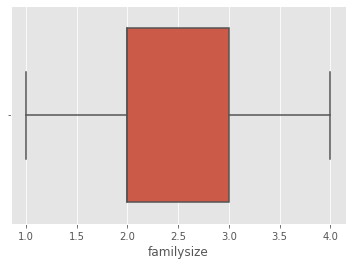

In [36]:
# Handling outlier : 'familysize'
Q1 = processed_data['familysize'].quantile(0.25)
Q2 = processed_data['familysize'].quantile(0.5)
Q3 = processed_data['familysize'].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - (1.5 * IQR)
upper_fence = Q3 + (1.5 * IQR)

processed_data['familysize'] = processed_data['familysize'].apply(lambda x : np.nan if x < lower_fence or x > upper_fence else x)
sns.boxplot(x='familysize', data=processed_data)

<AxesSubplot:>

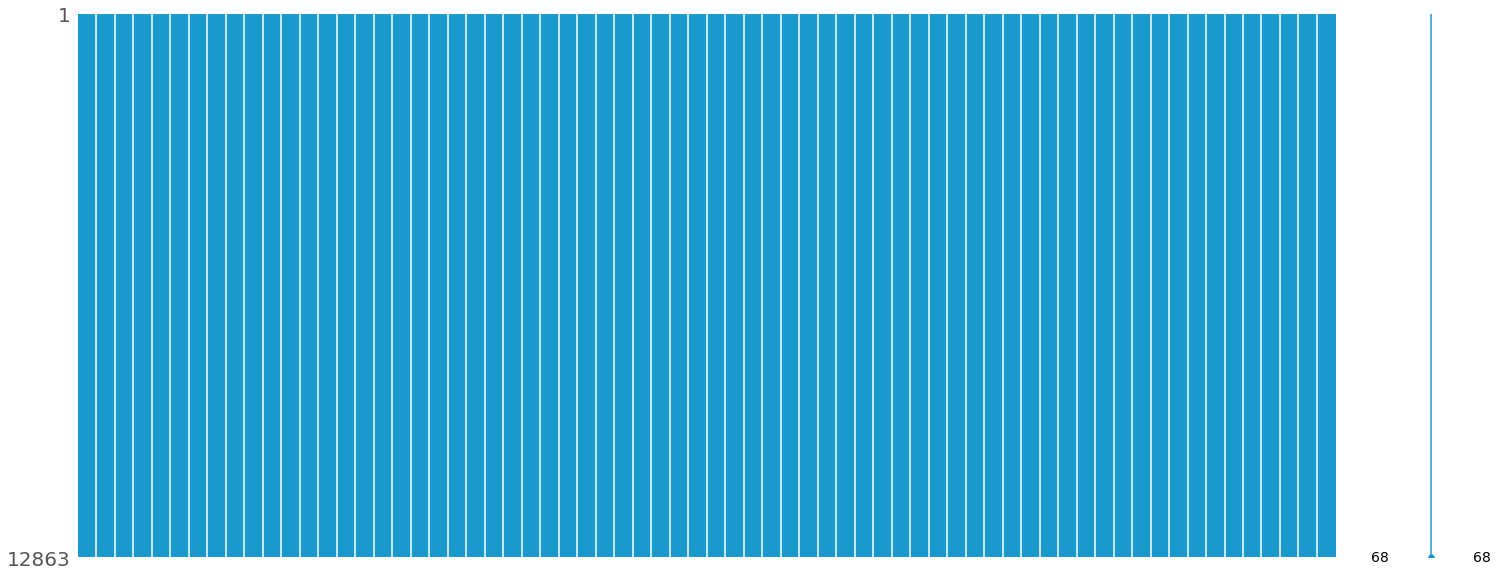

In [37]:
processed_data = processed_data.dropna().copy()
msno.matrix(processed_data.iloc[:, :], color=(0.1, 0.6, 0.8))

In [38]:
processed_data

,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,hand,religion,...,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16
0,1.39,6.32,1.95,2.00,1,3.00,1.00,1.00,2.00,12.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
1,1.79,4.45,4.80,4.00,2,2.00,1.00,3.00,1.00,2.00,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
2,2.30,4.69,4.62,2.00,1,1.00,2.00,3.00,1.00,2.00,...,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
3,1.10,4.80,4.94,1.00,3,1.00,1.00,0.00,2.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
4,1.39,6.46,5.38,1.00,2,2.00,2.00,0.00,2.00,12.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.56,4.64,5.09,2.00,2,2.00,1.00,0.00,1.00,1.00,...,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
14996,3.47,4.67,5.19,4.00,1,2.00,2.00,3.00,1.00,3.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
14997,2.89,4.64,5.13,2.00,2,2.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
14998,2.71,4.23,4.70,3.00,2,2.00,1.00,1.00,1.00,12.00,...,0.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


# 모델 학습

In [39]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data

,introelapse,testelapse,surveyelapse,education,urban,gender,engnat,age,hand,religion,...,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16
0,1.39,6.32,1.95,2.00,1,3.00,1.00,1.00,2.00,12.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
1,1.79,4.45,4.80,4.00,2,2.00,1.00,3.00,1.00,2.00,...,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
2,2.30,4.69,4.62,2.00,1,1.00,2.00,3.00,1.00,2.00,...,1.00,1.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
3,1.10,4.80,4.94,1.00,3,1.00,1.00,0.00,2.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
4,1.39,6.46,5.38,1.00,2,2.00,2.00,0.00,2.00,12.00,...,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.56,4.64,5.09,2.00,2,2.00,1.00,0.00,1.00,1.00,...,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00
14996,3.47,4.67,5.19,4.00,1,2.00,2.00,3.00,1.00,3.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00
14997,2.89,4.64,5.13,2.00,2,2.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00
14998,2.71,4.23,4.70,3.00,2,2.00,1.00,1.00,1.00,12.00,...,0.00,1.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


In [40]:
input_data_y = input_data['nerdiness'].copy()
input_data_X = input_data.drop(['nerdiness'], axis=1).copy()

In [41]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV

# train/ test data 로 split 
train_X, test_X, train_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    random_state = 7,
    shuffle=True
)

In [42]:
# from lightgbm import LGBMClassifier
# from lightgbm import plot_importance 
# from xgboost import XGBClassifier
# from xgboost import plot_importance
# from catboost import CatBoostClassifier
# #from catboost import plot_importance
from sklearn.ensemble import RandomForestClassifier

from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, classification_report

model_rf = RandomForestClassifier()

In [43]:
# RF
kfold = KFold(n_splits = 5, shuffle=True, random_state = 7)
cv_roc = []

n_iter = 0
for train_idx, test_idx in kfold.split(train_X) :
    trainX, validX = train_X.iloc[train_idx], train_X.iloc[test_idx]
    trainy, validy = train_y.iloc[train_idx], train_y.iloc[test_idx]
    eval_set = [(validX, validy)]
    
    model_rf.fit(trainX, trainy)
    pred_fold = model_rf.predict(validX)
    roc = roc_auc_score(validy, pred_fold)
    
    n_iter += 1 
    print("\n{} 교차검증 정확도 : {}, 학습 데이터 크기 : {}, 검증 데이터 크기 {}".format(n_iter, roc, trainX.shape[0], validX.shape[0]))
    cv_roc.append(roc)
    
print("\n\n 평균 검증 정확도 : ", np.mean(cv_roc))


1 교차검증 정확도 : 0.7688950357176709, 학습 데이터 크기 : 8232, 검증 데이터 크기 2058

2 교차검증 정확도 : 0.750817226824082, 학습 데이터 크기 : 8232, 검증 데이터 크기 2058

3 교차검증 정확도 : 0.758064531624531, 학습 데이터 크기 : 8232, 검증 데이터 크기 2058

4 교차검증 정확도 : 0.7676188824829858, 학습 데이터 크기 : 8232, 검증 데이터 크기 2058

5 교차검증 정확도 : 0.7871386540886378, 학습 데이터 크기 : 8232, 검증 데이터 크기 2058


 평균 검증 정확도 :  0.7665068661475816
